# DarkELF multiphonon spin dependent notebook

This notebook is meant to illustrate the part of the darkELF package for calculating dark matter-phonon rates in the multiphonon regime for a spin dependent interaction.

written by Ethan & Bethany, updated 3/25/2025

In [11]:
%matplotlib inline

import sys, os
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import rc, rcParams
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from tqdm import tqdm
import pandas
from scipy import interpolate
import seaborn as sns

# Make use of TeX\ufeff
rc('text',usetex=True)
# Change all fonts to 'Computer Modern'
rc('font',**{'size':14, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=5, pad=7)
rc('xtick', labelsize=15)
rc('ytick.major', size=5, pad=7)
rc('ytick', labelsize=15)

# this needs to point to the folder where darkelf.py is stored
work_dir = os.getcwd()
sys.path.append(work_dir+"/..")
plotdir=work_dir+"/plots/"

# load the package
from darkelf import darkelf, targets

## Load the materials

DarkELF comes with a number of pre-tabulate data files, which encode important properties of the materials which are difficult and/or slow to compute on the fly. The list of available data files can be accessed with the "targets.files()" command, as illustrated below.

In [2]:
targets.files('GaAs')

Available configuration files: 
	 GaAs.yaml
 
Available data for epsilon: 
	 GaAs_mermin.dat
	 GaAs_epsphonon_data10K.dat
 
Available data for phonon (partial) density of states: 
	 Ga_pDoS.dat
	 As_pDoS.dat
 
Available data for Fn(omega) functions: 
	 As_Fn.dat
	 Ga_Fn.dat
 
Available data for form factors: 
	 Ga_Zion.dat
	 Ga_atomic_Zion.dat
	 As_Zion.dat
	 As_atomic_Zion.dat


# For the example above:
    
*    GaAs.yaml contains global properties of the material, such as mass density, atomic numbers etc
*    The espilon data tables parametrize the dielectric function in various regimes and with different computational methods. The dielectric function is not used in the multiphonon calculations. (See darkelf_epsilon.ipynb for details)
*    The phonon partial density of states are needed to compute the multiphonon rate, and were take from the Materials Project. (https://materialsproject.org/) By default, darkELF loads the density of state tables that came with the package, but the user can choose to insert their own extraction by adding the file to the folder of the corresponding material. The user-supplied (p)DOS can then be loaded with the "dos_filename" flag. This flag accepts a single filename as well as a list of filenames. In the former case, it interprets the file as the full DOS of the material. In the latter case, each file will be interpretted as a pDOS.

*    To speed up the computations, the multiphonon rate is computed with pretabulated auxiliary functions "Fn". The default "Fn" functions are calculated for the default density of states provided with darkELF. If using your own density of states, you must first run the "create_Fn_omega()" function on the desired density of states to recompute these pretabulated functions. (See below.) Beware that this step is somewhat time consuming. If the desired pDOS is specified with the "dos_filename" flag, darkELF will automatically load the corresponding Fn table.
   

Let's load a few materials.

In [12]:
gaas = darkelf(target='GaAs')
print("------")
al2o3 = darkelf(target='Al2O3')
print("------")

 .... Loading files for GaAs
Loaded GaAs_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from Y. Tu, C. Kwei and C. Tung,Angular and energy dependences of the surface excitation parameter for semiconducting iii–v compounds, Surface Science601(2007) 865.
phonon ELF taken or calculated from H.M. Lawler and E.L. Shirley, Anharmonic effects on infrared spectra of GaAs and gap:  First-principles calculations, Phys. Rev. B70(2004) 245209 and E.D. Palik, Gallium arsenide (gaas), in Handbook of Optical Constants of Solids, E.D. Palik, ed.,pp. 429–443, Elsevier (1985).
Loaded GaAs_epsphonon_data10K.dat for epsilon in phonon regime
Warning, GaAs_eps_electron_opticallimit.dat does not exist! dielectric function in optical limit not loaded. Needed for absorption calculations in superconductors.
Warning! Atomic Migdal calculation not present
Warning! Momentum dependent Zion for Migdal calculation not loaded. Using Z - number of valence electrons.
Loaded /Users/tongyan/D

/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/epsilon.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(inplace=True,method='bfill')# fill in some NaN values


Loaded /Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/GaAs/GaAs_pDoS_anisotropic.dat for partial densities of states
GaAs_pDoS_anisotropic.dat
/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/GaAs/GaAs_Fn.npy
Warning! GaAs_Fn_anisotropic.npy does not exist! Need to calculate Fn(omega) from DoS. Use the function 'F_n_d_precompute' to produce these files 
------
 .... Loading files for Al2O3
Loaded Al2O3_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from Y. Sun, H. Xu, B. Da, S.-f. Mao and Z.-j. Ding, Calculations of Energy-Loss Function for 26 Materials, Chinese Journal of Chemical Physics9(2016) 663.
phonon ELF taken or calculated from  F. Gervais and B. Piriou, Anharmonicity in several-polar-mode crystals:  adjusting phonon self-energy of LO and TO modes in Al2O3 and TiO2 to fit infrared reflectivity,Journal of Physics C Solid State Physics 7 (1974) 2374 and M. Schubert, T.E. Tiwald and C.M. Herzinger, Infrared die

/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/epsilon.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(inplace=True,method='bfill')# fill in some NaN values


Loaded /Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/Al2O3/Al2O3_pDoS_anisotropic.dat for partial densities of states
Al2O3_pDoS_anisotropic.dat
/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/Al2O3/Al2O3_Fn.npy
Loaded Al2O3_Fn_anisotropic.npy for Fn(omega)
------


# Cross section plots

Now using the sigma_multiphonon_SD function to calculate the required DM-nucleon cross-section for a rate of 3 events/kg/yr. We can choose from several different spin dependent operators.

In [13]:
?gaas.sigma_multiphonons_SD

Signature: gaas.sigma_multiphonons_SD(threshold, nucleon='p', nuclear_recoil=False)
Docstring:
returns DM-proton cross-section [cm^2] corresponding to 3 events/kg/yr
Inputs
------
threshold: float
  experimental threshold, in eV
nucleon: string
  Choose from p or n. If this matches the defined ratio of g_p and g_n, the
  calculation will proceed. Otherwise, you will be prompted to reset the ratio

nuclear_recoil: boolean
    If true, will use the SD cross section assuming pure nuclear recoil.
File:      ~/Dropbox/Projects/DarkELF/darkelf/multiphonon_spin_dependent.py
Type:      method

100%|██████████| 50/50 [01:30<00:00,  1.81s/it]


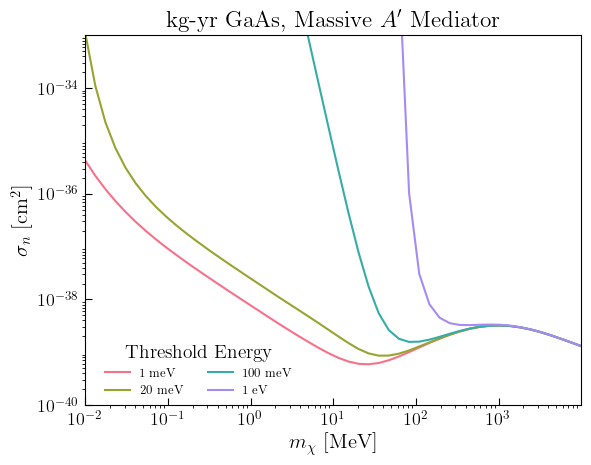

In [14]:
import seaborn as sns

points = 50

mdm = np.logspace(4, 10, points)

reaches1 = np.zeros(points)
reaches2 = np.zeros(points)
reaches3 = np.zeros(points)
reaches4 = np.zeros(points)

import time

for i, mass in enumerate(tqdm(mdm)):
    gaas.update_params(mX = mass, mediator = 'massive', SD_op = "A'") # update the DM mass
    if(mass > 1e9): 
        nuclear_recoil=True
    else:
        nuclear_recoil=False
    reaches1[i] = gaas.sigma_multiphonons_SD(threshold=1e-3, nuclear_recoil=nuclear_recoil)
    reaches2[i] = gaas.sigma_multiphonons_SD(threshold=20e-3, nuclear_recoil=nuclear_recoil)
    reaches3[i] = gaas.sigma_multiphonons_SD(threshold=1e-1, nuclear_recoil=nuclear_recoil)
    reaches4[i] = gaas.sigma_multiphonons_SD(threshold=1, nuclear_recoil=nuclear_recoil)
        
colors = sns.color_palette("husl", 4)

fig, ax = plt.subplots()


ax.plot(mdm/1e6, reaches1, label='$1$ meV', color=colors[0])
ax.plot(mdm/1e6, reaches2, label='$20$ meV', color=colors[1])
ax.plot(mdm/1e6, reaches3, label='$100$ meV', color=colors[2])
ax.plot(mdm/1e6, reaches4, label='$1$ eV', color=colors[3])


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$m_\chi \ [\mathrm{MeV}]$',fontsize=15)
ax.set_ylabel(r'$\sigma_n \ [\mathrm{cm}^2]$',fontsize=15)

ax.tick_params(axis="both",which="major",labelsize=13,direction="in",pad=5)

ax.set_title(r"kg-yr GaAs, Massive $A'$ Mediator")

ax.set_xlim([1e-2,1e4])
ax.set_ylim([1e-40,1e-33])

xtick_major = [pow(10.,n) for n in range(-2,4,1)]
ytick_major = [pow(10.,n) for n in range(-40,-33,2)]
ax.set_yticks(ytick_major)
ax.set_xticks(xtick_major)

ax.legend(loc=(0.03,0.01),fontsize=9,frameon=False,ncol=2,title='Threshold Energy')

#plt.savefig(plotdir+"gaas_heavy_multiphonon_SD.pdf",bbox_inches='tight')


100%|██████████| 50/50 [01:29<00:00,  1.78s/it]


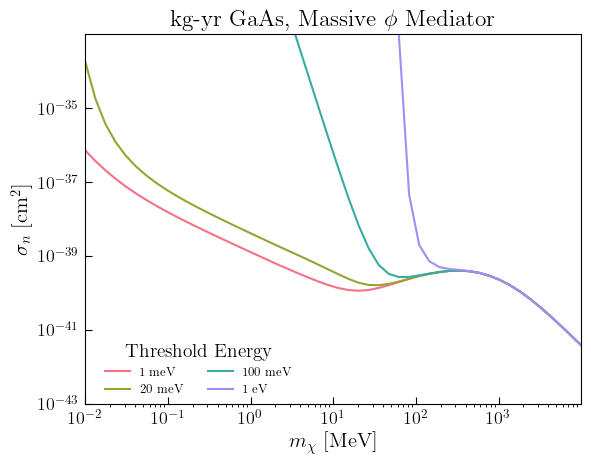

In [15]:
import seaborn as sns

points = 50

mdm = np.logspace(4, 10, points)

reaches1 = np.zeros(points)
reaches2 = np.zeros(points)
reaches3 = np.zeros(points)
reaches4 = np.zeros(points)

import time

for i, mass in enumerate(tqdm(mdm)):
    gaas.update_params(mX = mass, mediator = 'massive', SD_op = "phi") # update the DM mass
    if(mass > 1e9): 
        nuclear_recoil=True
    else:
        nuclear_recoil=False
    reaches1[i] = gaas.sigma_multiphonons_SD(threshold=1e-3, nuclear_recoil=nuclear_recoil)
    reaches2[i] = gaas.sigma_multiphonons_SD(threshold=20e-3, nuclear_recoil=nuclear_recoil)
    reaches3[i] = gaas.sigma_multiphonons_SD(threshold=1e-1, nuclear_recoil=nuclear_recoil)
    reaches4[i] = gaas.sigma_multiphonons_SD(threshold=1, nuclear_recoil=nuclear_recoil)
        
colors = sns.color_palette("husl", 4)

fig, ax = plt.subplots()


ax.plot(mdm/1e6, reaches1, label='$1$ meV', color=colors[0])
ax.plot(mdm/1e6, reaches2, label='$20$ meV', color=colors[1])
ax.plot(mdm/1e6, reaches3, label='$100$ meV', color=colors[2])
ax.plot(mdm/1e6, reaches4, label='$1$ eV', color=colors[3])


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$m_\chi \ [\mathrm{MeV}]$',fontsize=15)
ax.set_ylabel(r'$\sigma_n \ [\mathrm{cm}^2]$',fontsize=15)

ax.tick_params(axis="both",which="major",labelsize=13,direction="in",pad=5)

ax.set_title(r"kg-yr GaAs, Massive $\phi$ Mediator")

ax.set_xlim([1e-2,1e4])
ax.set_ylim([1e-43,1e-33])

xtick_major = [pow(10.,n) for n in range(-2,4,1)]
ytick_major = [pow(10.,n) for n in range(-43,-33,2)]
ax.set_yticks(ytick_major)
ax.set_xticks(xtick_major)

ax.legend(loc=(0.03,0.01),fontsize=9,frameon=False,ncol=2,title='Threshold Energy')

#plt.savefig(plotdir+"gaas_heavy_multiphonon_SD.pdf",bbox_inches='tight')


100%|██████████| 50/50 [01:29<00:00,  1.79s/it]


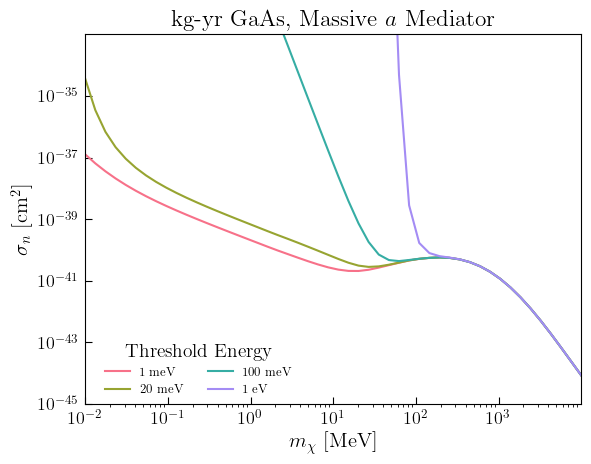

In [16]:
import seaborn as sns

points = 50

mdm = np.logspace(4, 10, points)

reaches1 = np.zeros(points)
reaches2 = np.zeros(points)
reaches3 = np.zeros(points)
reaches4 = np.zeros(points)

import time

for i, mass in enumerate(tqdm(mdm)):
    gaas.update_params(mX = mass, mediator = 'massive', SD_op = "a") # update the DM mass
    if(mass > 1e9): 
        nuclear_recoil=True
    else:
        nuclear_recoil=False
    reaches1[i] = gaas.sigma_multiphonons_SD(threshold=1e-3, nuclear_recoil=nuclear_recoil)
    reaches2[i] = gaas.sigma_multiphonons_SD(threshold=20e-3, nuclear_recoil=nuclear_recoil)
    reaches3[i] = gaas.sigma_multiphonons_SD(threshold=1e-1, nuclear_recoil=nuclear_recoil)
    reaches4[i] = gaas.sigma_multiphonons_SD(threshold=1, nuclear_recoil=nuclear_recoil)

colors = sns.color_palette("husl", 4)

fig, ax = plt.subplots()


ax.plot(mdm/1e6, reaches1, label='$1$ meV', color=colors[0])
ax.plot(mdm/1e6, reaches2, label='$20$ meV', color=colors[1])
ax.plot(mdm/1e6, reaches3, label='$100$ meV', color=colors[2])
ax.plot(mdm/1e6, reaches4, label='$1$ eV', color=colors[3])


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$m_\chi \ [\mathrm{MeV}]$',fontsize=15)
ax.set_ylabel(r'$\sigma_n \ [\mathrm{cm}^2]$',fontsize=15)

ax.tick_params(axis="both",which="major",labelsize=13,direction="in",pad=5)

ax.set_title(r"kg-yr GaAs, Massive $a$ Mediator")

ax.set_xlim([1e-2,1e4])
ax.set_ylim([1e-45,1e-33])

xtick_major = [pow(10.,n) for n in range(-2,4,1)]
ytick_major = [pow(10.,n) for n in range(-45,-33,2)]
ax.set_yticks(ytick_major)
ax.set_xticks(xtick_major)

ax.legend(loc=(0.03,0.01),fontsize=9,frameon=False,ncol=2,title='Threshold Energy')

#plt.savefig(plotdir+"gaas_heavy_multiphonon_SD.pdf",bbox_inches='tight')


100%|██████████| 50/50 [01:41<00:00,  2.04s/it]


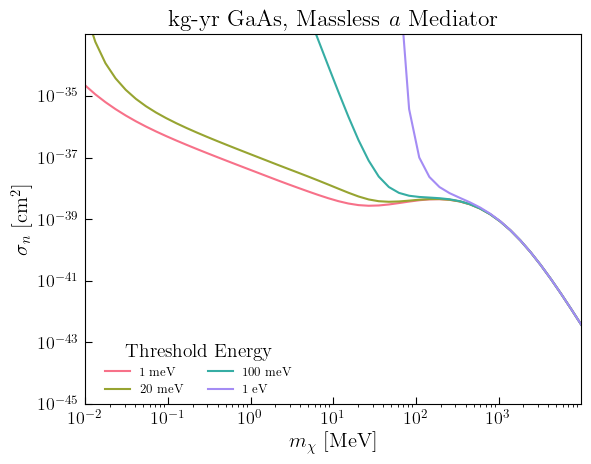

In [17]:
import seaborn as sns

points = 50

mdm = np.logspace(4, 10, points)

reaches1 = np.zeros(points)
reaches2 = np.zeros(points)
reaches3 = np.zeros(points)
reaches4 = np.zeros(points)

import time

for i, mass in enumerate(tqdm(mdm)):
    gaas.update_params(mX = mass, mMed = mass * 1e-4, SD_op = "a") # update the DM mass
    #if(mass > 1e9): 
    #    nuclear_recoil=True
    #else:
    nuclear_recoil=False
    reaches1[i] = gaas.sigma_multiphonons_SD(threshold=1e-3, nuclear_recoil=nuclear_recoil)
    reaches2[i] = gaas.sigma_multiphonons_SD(threshold=20e-3, nuclear_recoil=nuclear_recoil)
    reaches3[i] = gaas.sigma_multiphonons_SD(threshold=1e-1, nuclear_recoil=nuclear_recoil)
    reaches4[i] = gaas.sigma_multiphonons_SD(threshold=1, nuclear_recoil=nuclear_recoil)

colors = sns.color_palette("husl", 4)

fig, ax = plt.subplots()


ax.plot(mdm/1e6, reaches1, label='$1$ meV', color=colors[0])
ax.plot(mdm/1e6, reaches2, label='$20$ meV', color=colors[1])
ax.plot(mdm/1e6, reaches3, label='$100$ meV', color=colors[2])
ax.plot(mdm/1e6, reaches4, label='$1$ eV', color=colors[3])


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$m_\chi \ [\mathrm{MeV}]$',fontsize=15)
ax.set_ylabel(r'$\sigma_n \ [\mathrm{cm}^2]$',fontsize=15)

ax.tick_params(axis="both",which="major",labelsize=13,direction="in",pad=5)

ax.set_title(r"kg-yr GaAs, Massless $a$ Mediator")

ax.set_xlim([1e-2,1e4])
ax.set_ylim([1e-45,1e-33])

xtick_major = [pow(10.,n) for n in range(-2,4,1)]
ytick_major = [pow(10.,n) for n in range(-45,-33,2)]
ax.set_yticks(ytick_major)
ax.set_xticks(xtick_major)

ax.legend(loc=(0.03,0.01),fontsize=9,frameon=False,ncol=2,title='Threshold Energy')

#plt.savefig(plotdir+"gaas_heavy_multiphonon_SD.pdf",bbox_inches='tight')


If starting with a new density of states, one must run the 'create_Fn_omega()' function. (see below.) This defaults to creating the Fn functions corresponding to the density of states (or list of partial density of states) loaded in in the instantiation of the class.

# Differential Rate $\frac{dR}{d\omega}$

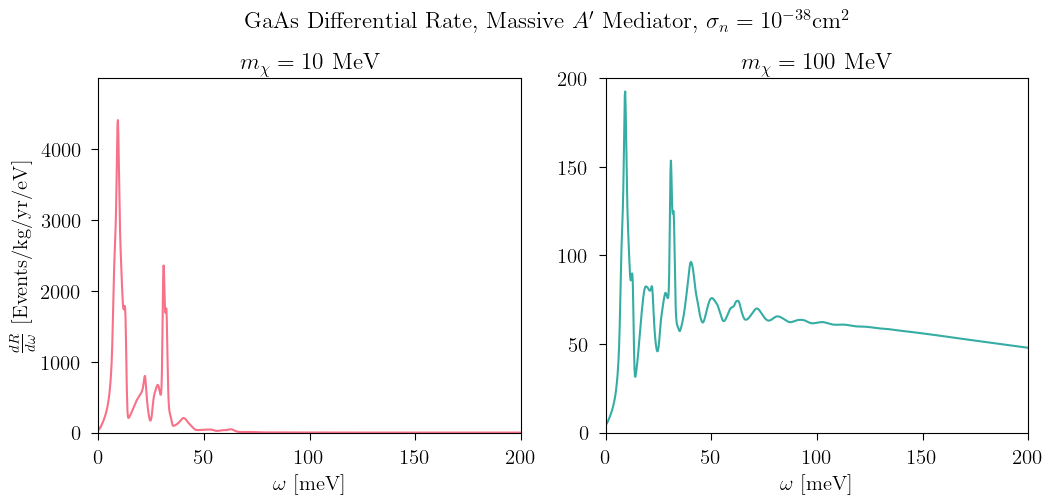

In [18]:
omegarange = np.linspace(1e-4, 200e-3, 2000)

gaas.update_params(mX = 1e7, mMed = 1e9, SD_op = "A'") # update the DM mass

dr_domega1 = [gaas._dR_domega_multiphonons_SD(omega) for omega in omegarange]

gaas.update_params(mX = 1e8, mMed = 1e9, SD_op = "A'") # update the DM mass

dr_domega2 = [gaas._dR_domega_multiphonons_SD(omega) for omega in omegarange]

colors = sns.color_palette("husl", 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.6))

ax1.plot(omegarange*1e3, dr_domega1, color=colors[0])
ax2.plot(omegarange*1e3, dr_domega2, color=colors[1])


ax1.set_xlabel(r'$\omega \ [\mathrm{meV}]$',fontsize=15)
ax2.set_xlabel(r'$\omega \ [\mathrm{meV}]$',fontsize=15)
ax1.set_ylabel(r'$\frac{dR}{d\omega} \ [\mathrm{Events}/\mathrm{kg}/\mathrm{yr}/\mathrm{eV}]$',fontsize=15)


ax1.set_title(r'$m_\chi = 10$ MeV')
ax2.set_title(r'$m_\chi = 100$ MeV')

ax1.set_xlim([0,200])
ax2.set_xlim([0,200])

ax1.set_ylim([0,5e3])
ax2.set_ylim([0,2e2])


xtick_major = [50*n for n in range(5)]
ytick_major = [1e3*n for n in range(5)]
ax1.set_yticks(ytick_major)

ax1.set_xticks(xtick_major)
ax2.set_xticks(xtick_major)

ytick_major = [0.5e2*n for n in range(5)]
ax2.set_yticks(ytick_major)

plt.suptitle(r"GaAs Differential Rate, Massive $A'$ Mediator, $\sigma_n = 10^{-38} \mathrm{cm}^2$", y=1.03)

plt.savefig(plotdir+"gaas_massive_rates_SD.pdf",bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.03, 'GaAs Differential Rate, Massless $a$ Mediator, $\\sigma_n = 10^{-38} \\mathrm{cm}^2$')

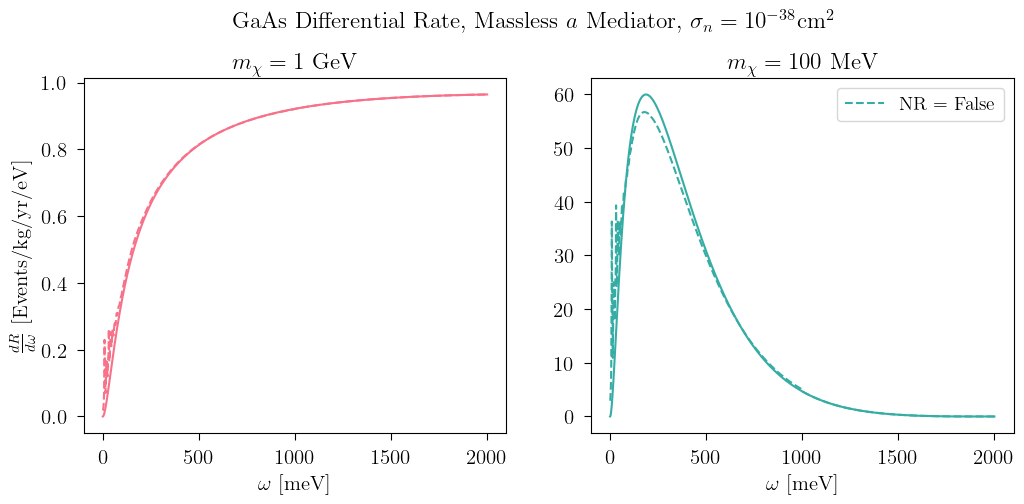

In [19]:
omegarange = np.linspace(1e-4, 2.0, 2000)

colors = sns.color_palette("husl", 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.6))

gaas.update_params(mX = 1e9, mMed = 1e5, SD_op = "a") # update the DM mass
dr_domega1 = [gaas._dR_domega_multiphonons_SD(omega, nuclear_recoil=True) for omega in omegarange]
ax1.plot(omegarange*1e3, dr_domega1, color=colors[0])
dr_domega1 = [gaas._dR_domega_multiphonons_SD(omega, nuclear_recoil=False) for omega in omegarange]
ax1.plot(omegarange*1e3, dr_domega1, color=colors[0], linestyle='--',label='NR = False')

plt.legend()

gaas.update_params(mX = 1e8, mMed = 1e5, SD_op = "a") # update the DM mass
dr_domega2 = [gaas._dR_domega_multiphonons_SD(omega, nuclear_recoil=True) for omega in omegarange]
ax2.plot(omegarange*1e3, dr_domega2, color=colors[1])
dr_domega2 = [gaas._dR_domega_multiphonons_SD(omega, nuclear_recoil=False) for omega in omegarange]
ax2.plot(omegarange*1e3, dr_domega2, color=colors[1], linestyle='--',label='NR = False')

plt.legend()


ax1.set_xlabel(r'$\omega \ [\mathrm{meV}]$',fontsize=15)
ax2.set_xlabel(r'$\omega \ [\mathrm{meV}]$',fontsize=15)
ax1.set_ylabel(r'$\frac{dR}{d\omega} \ [\mathrm{Events}/\mathrm{kg}/\mathrm{yr}/\mathrm{eV}]$',fontsize=15)


ax1.set_title(r'$m_\chi = 1$ GeV')
ax2.set_title(r'$m_\chi = 100$ MeV')

plt.suptitle(r'GaAs Differential Rate, Massless $a$ Mediator, $\sigma_n = 10^{-38} \mathrm{cm}^2$', y=1.03)


Text(0.5, 1.03, 'GaAs Differential Rate, Massive $a$ Mediator, $\\sigma_n = 10^{-38} \\mathrm{cm}^2$')

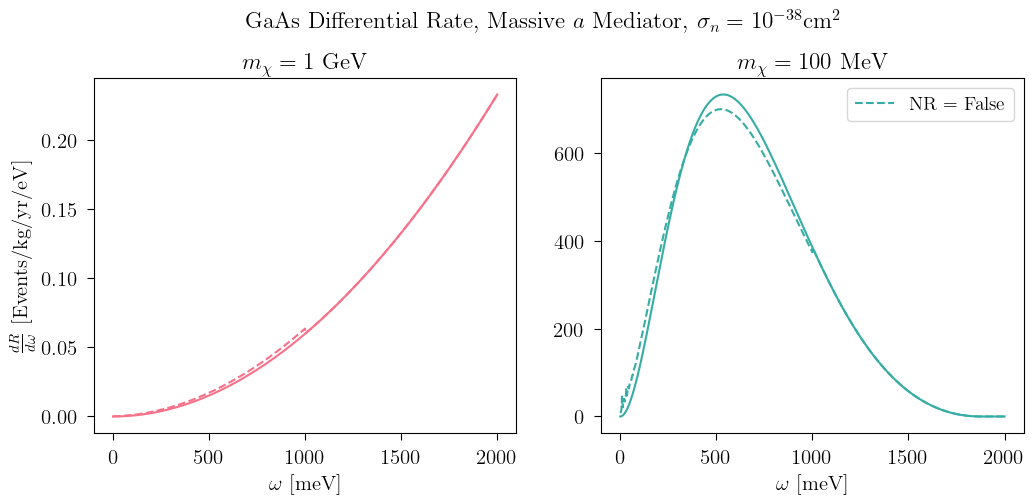

In [20]:
omegarange = np.linspace(1e-4, 2.0, 2000)

colors = sns.color_palette("husl", 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.6))

gaas.update_params(mX = 1e9, mMed = 1e12, SD_op = "a") # update the DM mass
dr_domega1 = [gaas._dR_domega_multiphonons_SD(omega, nuclear_recoil=True) for omega in omegarange]
ax1.plot(omegarange*1e3, dr_domega1, color=colors[0])
dr_domega1 = [gaas._dR_domega_multiphonons_SD(omega, nuclear_recoil=False) for omega in omegarange]
ax1.plot(omegarange*1e3, dr_domega1, color=colors[0], linestyle='--')

gaas.update_params(mX = 1e8, mMed = 1e12, SD_op = "a") # update the DM mass
dr_domega2 = [gaas._dR_domega_multiphonons_SD(omega, nuclear_recoil=True) for omega in omegarange]
ax2.plot(omegarange*1e3, dr_domega2, color=colors[1])
dr_domega2 = [gaas._dR_domega_multiphonons_SD(omega, nuclear_recoil=False) for omega in omegarange]
ax2.plot(omegarange*1e3, dr_domega2, color=colors[1], linestyle='--',label='NR = False')

plt.legend()


ax1.set_xlabel(r'$\omega \ [\mathrm{meV}]$',fontsize=15)
ax2.set_xlabel(r'$\omega \ [\mathrm{meV}]$',fontsize=15)
ax1.set_ylabel(r'$\frac{dR}{d\omega} \ [\mathrm{Events}/\mathrm{kg}/\mathrm{yr}/\mathrm{eV}]$',fontsize=15)


ax1.set_title(r'$m_\chi = 1$ GeV')
ax2.set_title(r'$m_\chi = 100$ MeV')

plt.suptitle(r'GaAs Differential Rate, Massive $a$ Mediator, $\sigma_n = 10^{-38} \mathrm{cm}^2$', y=1.03)


## Using a user-supplied DOS table

The user can update the pretabulated Fn function with their own density of states, using the "create_Fn_omega" function. To demonstrate how this works, we include the "Ga_pDoS_test.dat" and "As_pDoS_test.dat" files, which contain older versions of the pDoS that we used. They just serve to illustrate how to include user supplied pDOS files. We then make a new darkELF object, specifying these new pDOS files:

In [ ]:
# just deleting any potential left-over Fn files from previous runs
if os.path.isfile(work_dir+"/../data/GaAs/Ga_Fn_test.dat"):
    os.remove(work_dir+"/../data/GaAs/Ga_Fn_test.dat")        
if os.path.isfile(work_dir+"/../data/GaAs/As_Fn_test.dat"):
    os.remove(work_dir+"/../data/GaAs/As_Fn_test.dat")
    
gaas_test = darkelf(target='GaAs',dos_filename=["Ga_pDoS_test.dat","As_pDoS_test.dat"])

 .... Loading files for GaAs
Loaded GaAs_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from Y. Tu, C. Kwei and C. Tung,Angular and energy dependences of the surface excitation parameter for semiconducting iii–v compounds, Surface Science601(2007) 865.
phonon ELF taken or calculated from H.M. Lawler and E.L. Shirley, Anharmonic effects on infrared spectra of GaAs and gap:  First-principles calculations, Phys. Rev. B70(2004) 245209 and E.D. Palik, Gallium arsenide (gaas), in Handbook of Optical Constants of Solids, E.D. Palik, ed.,pp. 429–443, Elsevier (1985).
Loaded GaAs_epsphonon_data10K.dat for epsilon in phonon regime
Warning, GaAs_eps_electron_opticallimit.dat does not exist! dielectric function in optical limit not loaded. Needed for absorption calculations in superconductors.
Warning! Atomic Migdal calculation not present
Warning! Momentum dependent Zion for Migdal calculation not loaded. Using Z - number of valence electrons.
Loaded /Users/tongyan/D

/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/epsilon.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(inplace=True,method='bfill')# fill in some NaN values


Loaded /Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/GaAs/GaAs_pDoS_anisotropic.dat for partial densities of states
GaAs_pDoS_anisotropic.dat
/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/GaAs/GaAs_Fn.npy
Warning! GaAs_Fn_anisotropic.npy does not exist! Need to calculate Fn(omega) from DoS. Use the function 'F_n_d_precompute' to produce these files 


because GaAs is diatomic crystal, we specified both files a list as an argument to "dos_filename". Note that the definition of the object produces a warning if it doesn't find the Fn files, indicating that the user should run "create_Fn_omega", as below.

In [ ]:
gaas_test.create_Fn_omega()

result saved in /Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/GaAs/Ga_Fn_test.dat
result saved in /Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/GaAs/As_Fn_test.dat
Loaded /Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/GaAs/Ga_Fn_test.dat for Fn(omega)
Loaded /Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/GaAs/As_Fn_test.dat for Fn(omega)


At the end of this process, a the output will be stored in as a look-up table in a new "Fn" file, for future usage. The name of the Fn files is based on the name of the DoS files as follows


Ga_pDoS_test.dat --> Ga_Fn_test.dat

As_pDos_test.dat -> As_Fn_test.dat

 
etc. 

It is important that the filenames of all user-supplied DOS or partial DOS files include the string "DoS" or "pDoS" respectively. When running the code, it suffices to specify the desired DOS file(s) with the "dos_filename" flag in the constructor. DarkELF will then automatically load in the corresponding Fn-tables, or calculate them if needed.  If we now reload the darkELF object, the warning should have disappeared.

In [ ]:
gaas_test = darkelf(target='GaAs',dos_filename=["Ga_pDoS_test.dat","As_pDoS_test.dat"])
gaas = darkelf(target='GaAs')


 .... Loading files for GaAs
Loaded GaAs_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from Y. Tu, C. Kwei and C. Tung,Angular and energy dependences of the surface excitation parameter for semiconducting iii–v compounds, Surface Science601(2007) 865.
phonon ELF taken or calculated from H.M. Lawler and E.L. Shirley, Anharmonic effects on infrared spectra of GaAs and gap:  First-principles calculations, Phys. Rev. B70(2004) 245209 and E.D. Palik, Gallium arsenide (gaas), in Handbook of Optical Constants of Solids, E.D. Palik, ed.,pp. 429–443, Elsevier (1985).
Loaded GaAs_epsphonon_data10K.dat for epsilon in phonon regime
Warning, GaAs_eps_electron_opticallimit.dat does not exist! dielectric function in optical limit not loaded. Needed for absorption calculations in superconductors.
Warning! Atomic Migdal calculation not present
Warning! Momentum dependent Zion for Migdal calculation not loaded. Using Z - number of valence electrons.
Loaded /Users/tongyan/D

/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/epsilon.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(inplace=True,method='bfill')# fill in some NaN values


Loaded /Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/GaAs/GaAs_pDoS_anisotropic.dat for partial densities of states
GaAs_pDoS_anisotropic.dat
/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/GaAs/GaAs_Fn.npy
Warning! GaAs_Fn_anisotropic.npy does not exist! Need to calculate Fn(omega) from DoS. Use the function 'F_n_d_precompute' to produce these files 
 .... Loading files for GaAs
Loaded GaAs_mermin.dat for epsilon in electron regime
electronic ELF taken or calculated from Y. Tu, C. Kwei and C. Tung,Angular and energy dependences of the surface excitation parameter for semiconducting iii–v compounds, Surface Science601(2007) 865.
phonon ELF taken or calculated from H.M. Lawler and E.L. Shirley, Anharmonic effects on infrared spectra of GaAs and gap:  First-principles calculations, Phys. Rev. B70(2004) 245209 and E.D. Palik, Gallium arsenide (gaas), in Handbook of Optical Constants of Solids, E.D. Palik, ed.,pp. 429–443, Elsevier (1985).
Loaded G

/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/epsilon.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(inplace=True,method='bfill')# fill in some NaN values


Loaded /Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/GaAs/GaAs_pDoS_anisotropic.dat for partial densities of states
GaAs_pDoS_anisotropic.dat
/Users/tongyan/Dropbox/Projects/DarkELF/examples/../darkelf/../data/GaAs/GaAs_Fn.npy
Warning! GaAs_Fn_anisotropic.npy does not exist! Need to calculate Fn(omega) from DoS. Use the function 'F_n_d_precompute' to produce these files 


The new darkelf object can now be used for calculations

In [ ]:
print(gaas_test.sigma_multiphonons_SD(0.05))
print(gaas.sigma_multiphonons_SD(0.05))

1.1583937239376934e-31
1.1611810161621008e-31
